In [1]:
import pandas as pd

df = pd.read_csv("Bengaluru_House_Data.csv")
print(df.head())
print(df.info())

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   a

In [2]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

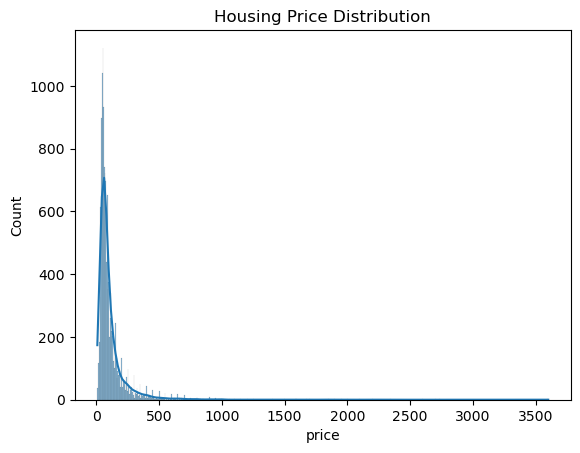

In [4]:
#distribution of price
sns.histplot(df['price'],kde=True)
plt.title("Housing Price Distribution")
plt.show()

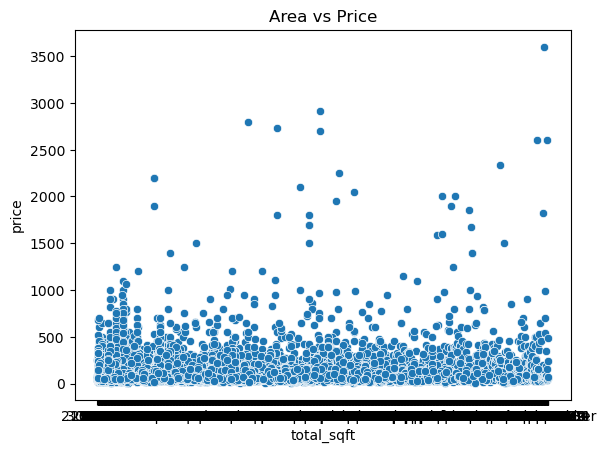

In [5]:
#price vs Area
sns.scatterplot(x='total_sqft', y='price', data=df)
plt.title("Area vs Price")
plt.show()

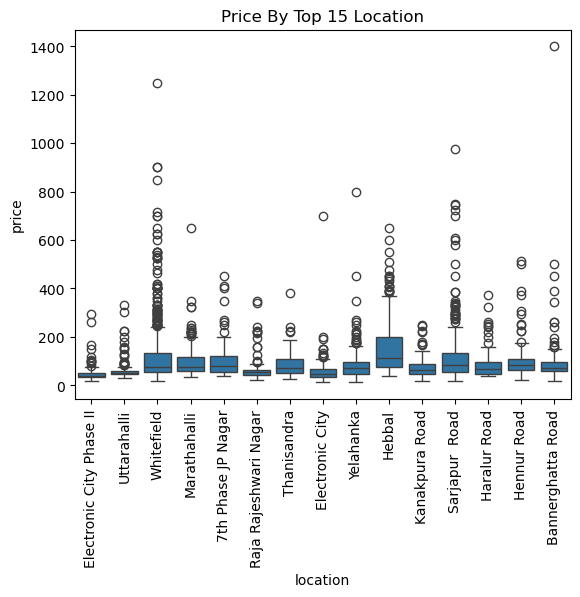

In [6]:
#price by location (top 15 locations)
top_locations=df['location'].value_counts().head(15).index
sns.boxplot(x='location',y='price',data=df[df['location'].isin(top_locations)])
plt.xticks(rotation=90)
plt.title("Price By Top 15 Location")
plt.show()

In [6]:
#convert total_sqft to float
def convert_sqft(x):
    try:
        return float(x)
    except:
        tokens = str(x).split('-')
        if len(tokens) == 2:
            try:
                return (float(tokens[0]) + float(tokens[1])) / 2
            except:
                return None
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df.dropna(subset=['total_sqft','bath','balcony','price'], inplace=True)

In [7]:
df = pd.get_dummies(df, columns=['area_type', 'availability'], drop_first=True)

# Simplify 'location' by grouping rare locations as 'other'
df['location'] = df['location'].apply(lambda x: str(x).strip())
location_counts = df['location'].value_counts()
less_common = location_counts[location_counts < 10].index
df['location'] = df['location'].apply(lambda x: 'other' if x in less_common else x)
df = pd.get_dummies(df, columns=['location'], drop_first=True)


In [8]:
df['price_per_sqft']= df['price']*100000/df['total_sqft']

In [9]:
df['bhk'] = df['size'].apply(lambda x: int(str(x).split()[0]) if pd.notnull(x) else None)
df.drop(['size', 'society'], axis=1, inplace=True)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select final features (excluding the raw price for training)
X = df.drop(['price', 'price_per_sqft'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = lr.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R²:', r2_score(y_test, y_pred))


RMSE: 104.65295450710887
R²: 0.47578837059901047


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print('Random Forest RMSE:', mean_squared_error(y_test, rf_pred, squared=False))
print('XGBoost RMSE:', mean_squared_error(y_test, xgb_pred, squared=False))


Random Forest RMSE: 84.49130786586784
XGBoost RMSE: 85.8826583763552


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


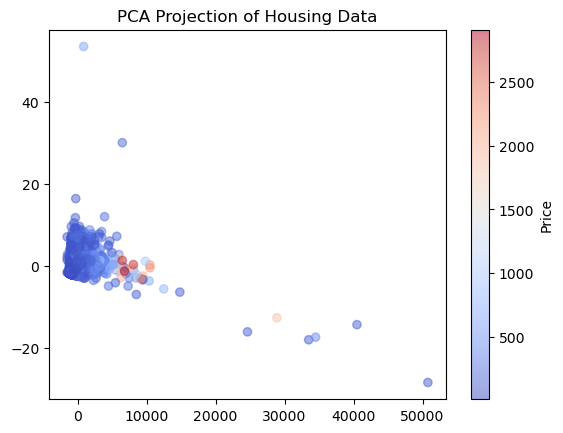

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.colorbar(label="Price")
plt.title("PCA Projection of Housing Data")
plt.show()


In [17]:
# streamlit_app.py
import streamlit as st
import pickle
import numpy as np

# Load your trained model
model = pickle.load(open('best_model.pkl', 'rb'))

st.title("Bengaluru House Price Prediction")

# Example user input
area = st.number_input('Area (sqft)')
bath = st.slider('Number of Bathrooms', 1, 5)
# ... add selectboxes or text input for other features

if st.button('Predict'):
    features = np.array([[area, bath, ...]])  # add all feature inputs as needed
    pred = model.predict(features)
    st.write(f"Predicted Price: ₹{pred[0]:,.2f} lakhs")


2025-07-26 02:09:50.467 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-07-26 02:09:50.468 Session state does not function when running a script without `streamlit run`


In [19]:
from sklearn.ensemble import RandomForestRegressor
import pickle

# Train your model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the column names (for later reconstruction of input features)
columns = X_train.columns.tolist()
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(columns, f)



In [20]:
import pickle

# Load model and training columns
model = pickle.load(open('best_model.pkl', 'rb'))
model_columns = pickle.load(open('model_columns.pkl', 'rb'))

